In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go

## Load  / Prep Data

In [2]:
treedf = pd.read_csv('./Final_app_work/categorized_data.csv')
#treedf.head().T

In [3]:
treedf['radius_change_micrometers'] = 10000 * treedf['change_stem_radius']

In [4]:
print(treedf.columns)

Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category', 'radius_change_micrometers'],
      dtype='object')


In [5]:
# Selecting non-categorical, non-engineered, non-target features for the analysis 
X = treedf[["average_stem_radius", "average_basal_area", 'freeze_flag',\
            "change_stem_radius",
           "average_air_temperature", "average_air_pressure", "average_humidity", "avg_solar_irradiance", \
           "avg_soil_water_content"]].dropna()

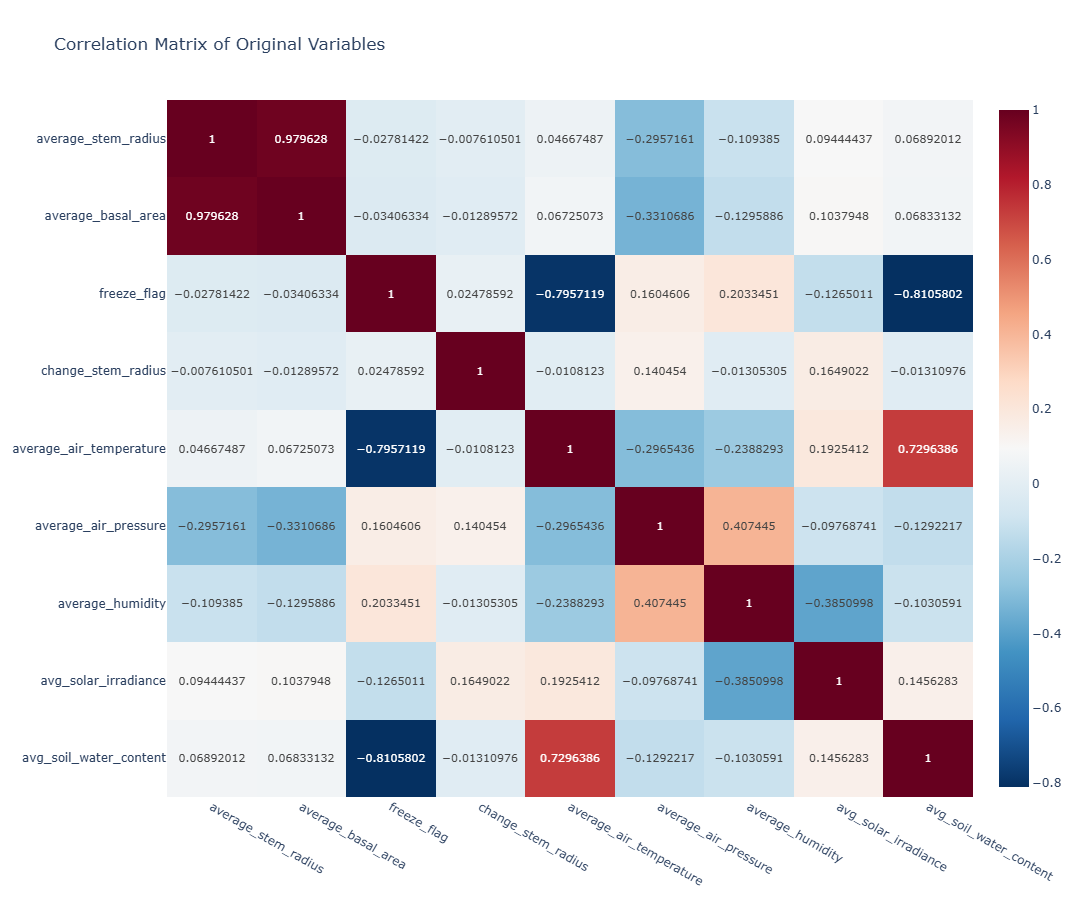

In [6]:
corr_X = X.corr()

fig_corr_X = px.imshow(
    corr_X,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Original Variables"
)
fig_corr_X.update_layout(
    width=900,
    height=900,
)
fig_corr_X.show()

(0.0, 300.0)

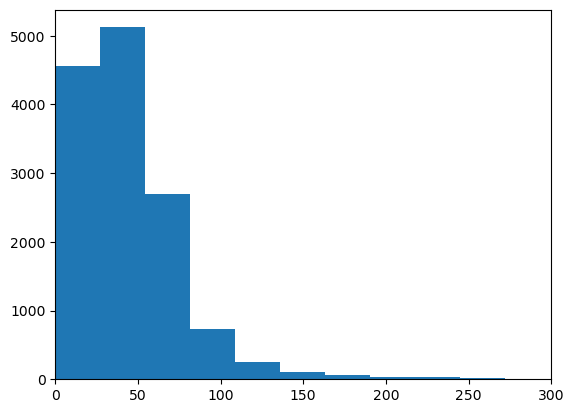

In [7]:
plt.hist(treedf['radius_change_micrometers'], bins=20)
plt.xlim(0,300)

## Creating Model

In [8]:
pca_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [9]:
pca_model = pca_pipe.named_steps["pca"]
explained_var = pca_model.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
n_components = len(explained_var)

ev_df = pd.DataFrame({
    "PC": np.arange(1, n_components + 1),
    "ExplainedVariance": explained_var,
    "CumulativeVariance": cum_explained_var
})


fig_scree = px.line(
    ev_df, x="PC", y="ExplainedVariance",
    markers=True,
    title="Scree Plot: Proportion of Variance Explained"
)

print('Explained variation per component:', explained_var)
print("Cumulative variation across components:", cum_explained_var)

Explained variation per component: [0.32277764 0.2296495  0.14378544 0.12432839 0.07977168 0.05269477
 0.02700455 0.0178309  0.00215712]
Cumulative variation across components: [0.32277764 0.55242714 0.69621258 0.82054097 0.90031265 0.95300743
 0.98001198 0.99784288 1.        ]


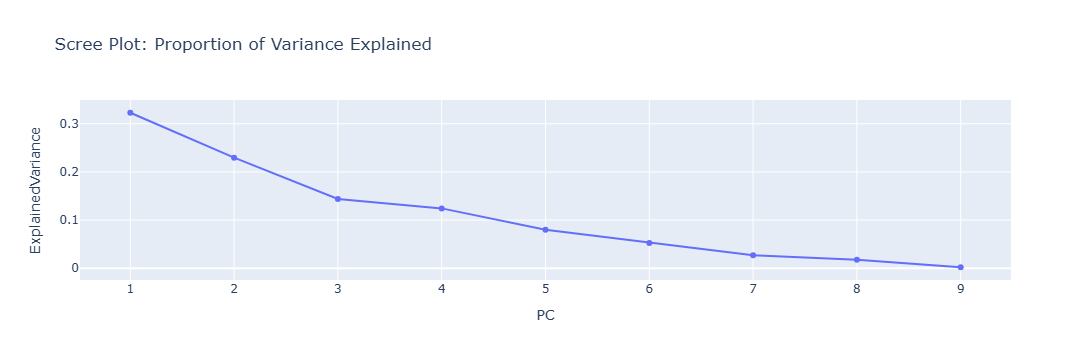

In [10]:
fig_scree.show()

In [11]:
X_pca_scores = pca_pipe.transform(X)
pc_cols = [f"PC{i}" for i in range(1, n_components + 1)]

scores_df = pd.DataFrame(X_pca_scores, columns=pc_cols)
scores_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     -0.560481  4.093919 -1.145066 -0.885315 -0.793485  0.497911 -0.251774   
1     -0.921031  3.991397 -1.003528 -0.731921 -0.083384 -0.444030 -0.336488   
2      1.745707  3.174559  1.105282  0.264544  0.505809 -0.476781  0.521643   
3      3.560803  2.794053  1.602151 -0.398564  1.288480 -0.445496  0.590703   
4      2.985554  2.252799 -0.528752  0.383239  0.115027 -0.067934  0.619472   
...         ...       ...       ...       ...       ...       ...       ...   
13632  1.379422  0.074159 -0.489638 -0.018803 -1.039763  0.347331 -0.880276   
13633  1.010598  0.961898  1.888933 -0.270096  0.013222  0.073538 -1.268124   
13634  1.486420 -0.081939 -0.200941  0.350221 -0.899770  0.027340 -0.562165   
13635  1.545520 -0.087710 -0.708388 -0.143743 -0.892155  0.207459 -0.581799   
13636  1.658898  0.152673  1.498218  1.807689 -2.184755 -0.090508 -1.072836   

            PC8       PC9  
0     -0.144122  0.188758  
1     -0.140012  0.217206  
2     -1.201119  0.186263  
3     -0.130475  0.175760  
4      0.163921  0.189832  
...         ...       ...  
13632 -0.114747 -0.158047  
13633  1.510828 -0.161551  
13634  0.049733 -0.156879  
13635  0.109532 -0.163117  
13636 -0.133460 -0.152216  

[13637 rows x 9 columns]

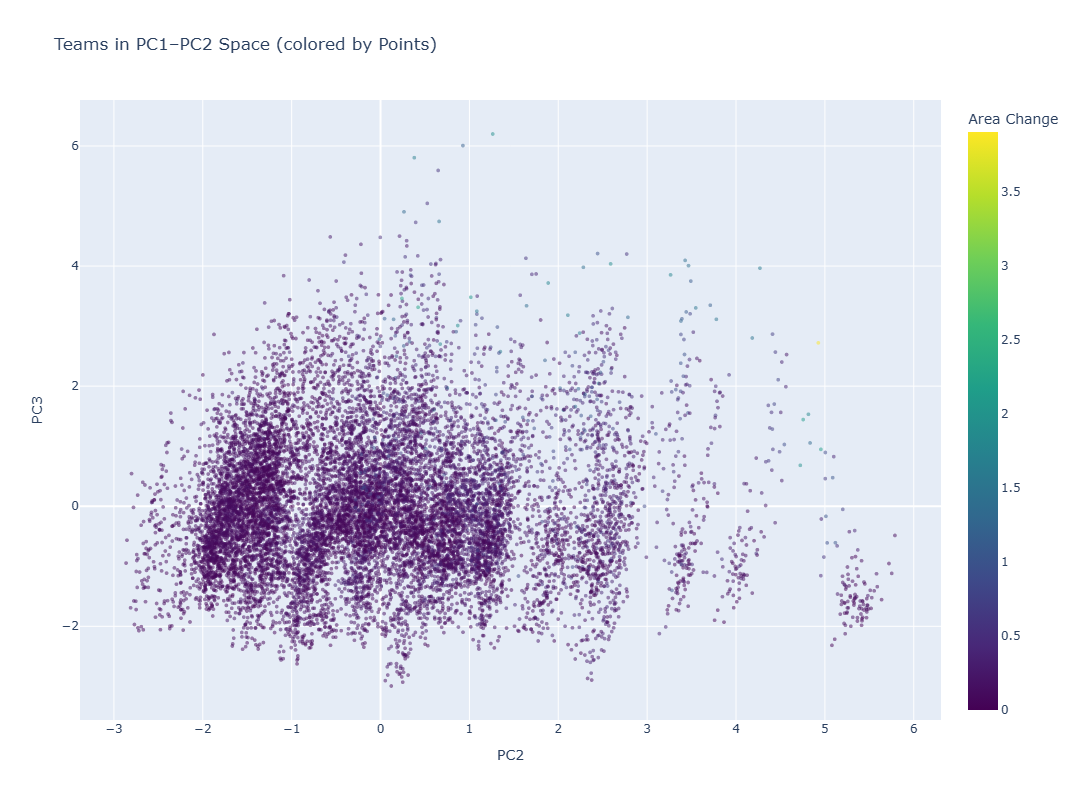

In [12]:
X_pca_scores = pca_pipe.transform(X)

'''
# Get indices of components > 0.09
important_indices = [i for i, var in enumerate(explained_var) if var > 0.09]
# Keep only PCs where explained variance > 0.09
pc_cols = [f"PC{i+1}" for i in important_indices]

X_pca_scores = X_pca_scores[:, important_indices]
'''

scores_df = pd.DataFrame(X_pca_scores, columns=pc_cols)
scores_df["Area Change"] = treedf['change_basal_area']
scores_df["Stem Radius Change (micrometers)"] = treedf['radius_change_micrometers']
scores_df["Stem Radius Change (centimeters)"] = treedf['change_stem_radius']
scores_df['species'] = treedf['species']
scores_df['plot'] = treedf['plot']
scores_df['Date'] = treedf['Date']


fig_scatter = px.scatter(
    scores_df,
    x="PC2", y="PC3",
    color="Area Change",
    hover_name="species",
    hover_data="Date",
    title="Teams in PC1–PC2 Space (colored by Points)",
    color_continuous_scale="Viridis",
    width=800,
    height=800,
    opacity=0.5
)

fig_scatter.update_traces(marker=dict(size=4)) 

fig_scatter.show()

## Investigating the Principal Components

In [13]:
# treedf columns
'''
['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_soil_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_cat', 'soil_moist_cat']
'''

"\n['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',\n       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',\n       'change_stem_radius', 'average_basal_area', 'change_basal_area',\n       'average_soil_temperature', 'average_air_pressure', 'average_humidity',\n       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',\n       'air_pressure_cat', 'humidity_cat', 'solar_cat', 'soil_moist_cat']\n"

In [14]:
result = pd.concat([treedf, scores_df],axis=1)
result = result.loc[:, ~result.columns.duplicated()]
result.sort_values('radius_change_micrometers', ascending=False).tail(20).T

1950              1893   \
Unnamed: 0                                    3369              3287   
site                                            AK                AK   
tree                                            1F                1F   
plot                                             1                 1   
species                                   P glauca          P glauca   
Date                                    2019-05-26        2019-05-20   
longitude                               -149.71558        -149.71558   
latitude                                 68.018659         68.018659   
da                                              26                20   
mo                                               5                 5   
wk                                              21                20   
yr                                            2019              2019   
average_stem_radius                          3.702             3.698   
change_stem_radius                             0.0               0.0   
average_basal_area                       43.054912          42.96192   
change_basal_area                              0.0               0.0   
average_air_temperature                   0.931944          0.633333   
average_air_pressure                      92.47256         92.700333   
average_humidity                          0.525077          0.668497   
avg_solar_irradiance                     113.02948         139.09022   
avg_soil_water_content                    0.284814          0.216719   
freeze_flag                                      0                 0   
air_pressure_cat                               low               low   
humidity_cat                                   dry               dry   
solar_rank                                 12498.0           13365.0   
solar_cat                                       Q4                Q4   
soil_moist_cat                            moderate          moderate   
growth_category                   No/Little Growth  No/Little Growth   
radius_change_micrometers                      0.0               0.0   
PC1                                       1.138721          0.723474   
PC2                                      -0.560044         -0.510171   
PC3                                       1.529156          1.384567   
PC4                                      -1.969125         -1.614243   
PC5                                       0.493846          0.877071   
PC6                                      -0.080822          0.735829   
PC7                                      -0.361046         -0.082531   
PC8                                      -0.530895         -0.901719   
PC9                                      -0.015483         -0.019064   
Area Change                                    0.0               0.0   
Stem Radius Change (micrometers)               0.0               0.0   
Stem Radius Change (centimeters)               0.0               0.0   

                                             9673              9676   \
Unnamed: 0                                   15839             15844   
site                                            AK                AK   
tree                                            3A                3A   
plot                                             3                 3   
species                                   P glauca          P glauca   
Date                                    2018-06-24        2017-08-24   
longitude                               -149.75301        -149.75301   
latitude                                 67.995233         67.995233   
da                                              24                24   
mo                                               6                 8   
wk                                              25                34   
yr                                            2018              2017   
average_stem_radius                          5.884             5.863   
change_stem_

Index(['Unnamed: 0', 'plot', 'longitude', 'latitude', 'da', 'mo', 'wk', 'yr',
       'average_stem_radius', 'change_stem_radius', 'average_basal_area',
       'change_basal_area', 'average_air_temperature', 'average_air_pressure',
       'average_humidity', 'avg_solar_irradiance', 'avg_soil_water_content',
       'freeze_flag', 'solar_rank', 'radius_change_micrometers', 'PC1', 'PC2',
       'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'Area Change',
       'Stem Radius Change (micrometers)', 'Stem Radius Change (centimeters)'],
      dtype='object')


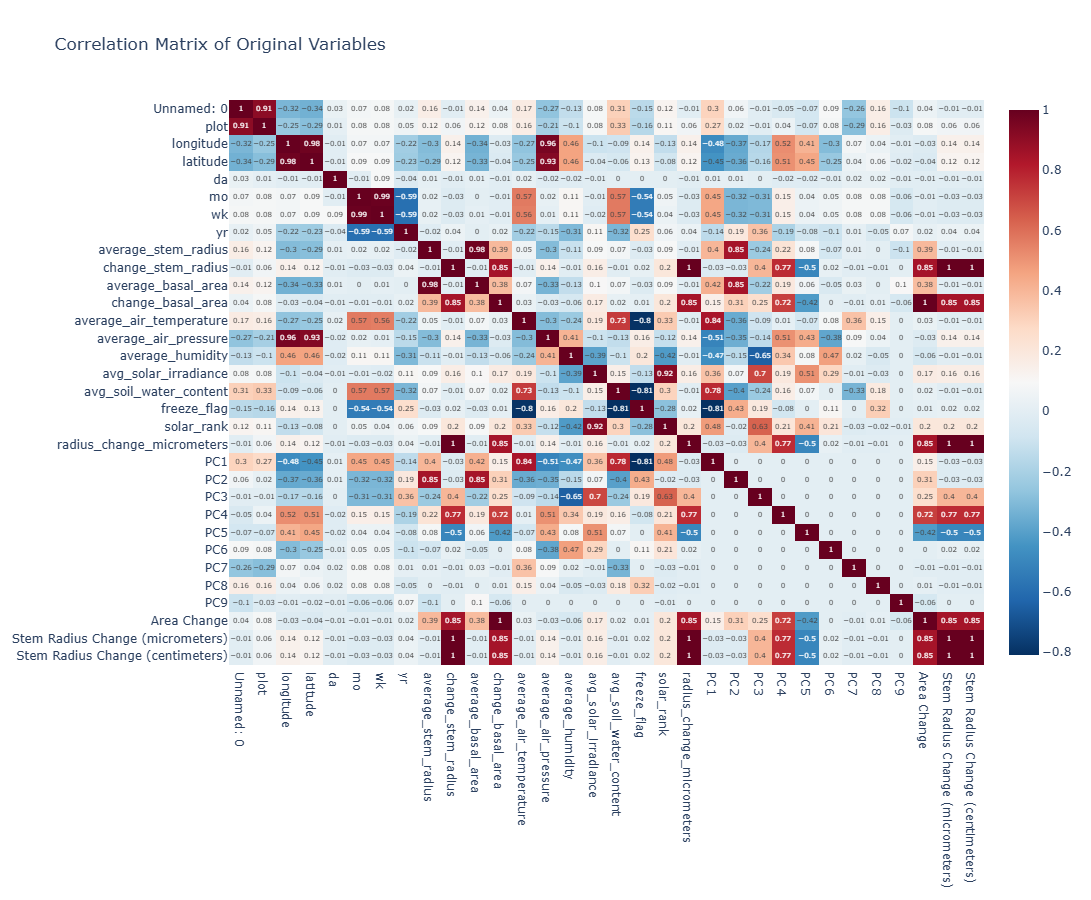

In [15]:
numeric_cols = result.select_dtypes(include=['number']).columns.tolist()
numeric_results = result[numeric_cols].loc[:, ~result[numeric_cols].columns.duplicated()]
num_corr = numeric_results.corr().round(2)

print(num_corr.columns)

fig_corr_numerics = px.imshow(
    num_corr,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="auto",
    title="Correlation Matrix of Original Variables"
)
fig_corr_numerics.update_layout(
    width=900,
    height=900,
)
fig_corr_numerics.show()

## Loadings

In [16]:
loadings = pca_model.components_.T[:, :4]
loading_df = pd.DataFrame(
    loadings,
    index=X.columns,
    columns=["PC1_loading", "PC2_loading", "PC3_loading", "PC4_loading"]
)

In [17]:
loading_df.head(10).T

average_stem_radius  average_basal_area  freeze_flag  \
PC1_loading             0.233314            0.244016    -0.476522   
PC2_loading             0.589357            0.591528     0.300141   
PC3_loading            -0.209675           -0.196248     0.165073   
PC4_loading             0.204254            0.181413    -0.075628   

             change_stem_radius  average_air_temperature  \
PC1_loading           -0.016540                 0.490986   
PC2_loading           -0.022155                -0.250219   
PC3_loading            0.350831                -0.083169   
PC4_loading            0.724576                 0.012439   

             average_air_pressure  average_humidity  avg_solar_irradiance  \
PC1_loading             -0.296747         -0.273105              0.210220   
PC2_loading             -0.245192         -0.102758              0.047304   
PC3_loading             -0.123297         -0.568160              0.613318   
PC4_loading              0.485422          0.319057              0.182533   

             avg_soil_water_content  
PC1_loading                0.459096  
PC2_loading               -0.276859  
PC3_loading               -0.214728  
PC4_loading                0.154058

In [18]:
print(result['growth_category'].unique())

['Moderate Growth' 'No/Little Growth' 'Extreme Growth']


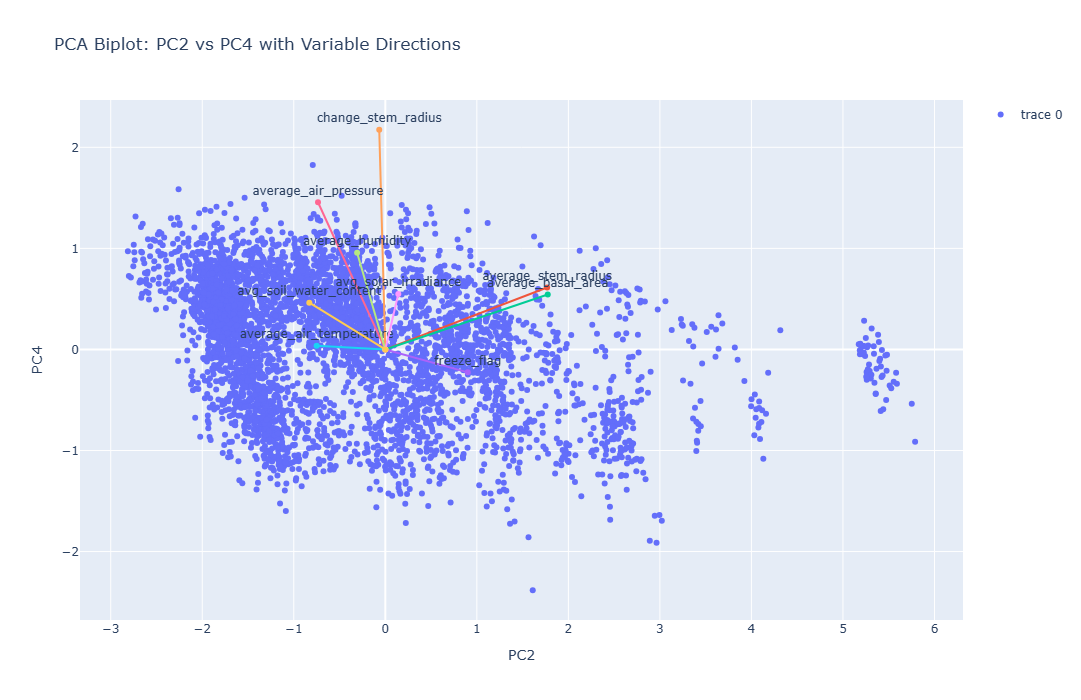

In [19]:
# Still two 'species' cols for some reason
result = result.loc[:, ~result.columns.duplicated()]
# Filter based on growth category
#growth_cat = 'No/Little Growth'
growth_cat = 'Moderate Growth'
#growth_cat = 'Extreme Growth'
growth = result[result["growth_category"] == growth_cat]

arrow_scale = 3

fig = go.Figure()


fig.add_trace(go.Scatter(
    x=growth["PC2"],
    y=growth["PC4"],
    mode="markers+text",
    #text=result_no_growth["species"],
    textposition="top center",
    #name="species",
    hovertext=[f"{t}, Change in Radius={p}" for t, p in zip(result["species"], result["radius_change_micrometers"])],
    #hoverinfo="text"
))


for var_name, row in loading_df.iterrows():
    x_arrow = row["PC2_loading"] * arrow_scale
    y_arrow = row["PC4_loading"] * arrow_scale


    fig.add_trace(go.Scatter(
        x=[0, x_arrow],
        y=[0, y_arrow],
        mode="lines+markers+text",
        text=[None, var_name],
        textposition="top center",
        showlegend=False
    ))

fig.update_layout(
    title="PCA Biplot: PC2 vs PC4 with Variable Directions",
    xaxis_title="PC2",
    yaxis_title="PC4",
    xaxis=dict(zeroline=True),
    yaxis=dict(zeroline=True),
    width=800,
    height=700
)

fig.show()


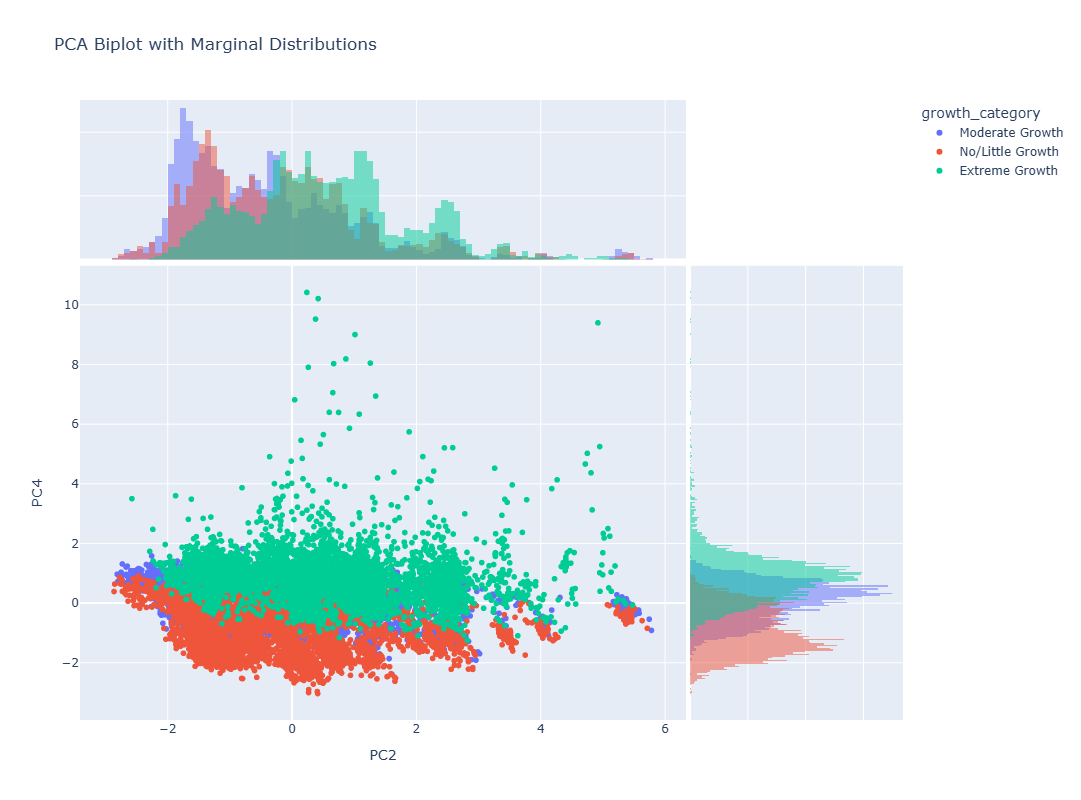

In [20]:
import plotly.express as px

fig = px.scatter(
    result,
    x="PC2",
    y="PC4",
    color="growth_category",
    marginal_x="histogram",  # or "box", "violin", "histogram", "rug"
    marginal_y="histogram",
    title="PCA Biplot with Marginal Distributions",
    hover_data=["species", "radius_change_micrometers"]
)

fig.update_layout(width=900, height=800)
fig.show()

## Principal Component REGRESSION

In [21]:
# NEED TO FIND CORRELATION BETWEEN COMPONENT AND Y

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Pipe with various numbers of principal components
n_pcs = 4
pcr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_pcs)),
    ("linreg", LinearRegression())
])

pcr_pipe.fit(X_train, y_train)


NameError: name 'y' is not defined

In [ ]:
train_r2 = pcr_pipe.score(X_train, y_train)
test_r2  = pcr_pipe.score(X_test, y_test)


y_train_pred = pcr_pipe.predict(X_train)
y_test_pred  = pcr_pipe.predict(X_test)

In [ ]:
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
test_rmse  = np.sqrt(np.mean((y_test - y_test_pred)**2))

print(f"Using n_components = {n_pcs}")
print(f"Train R²  : {train_r2:.4f}")
print(f"Test  R²  : {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")

In [ ]:
import plotly.express as px

# Predicted vs Actual plot for test data
fig = px.scatter(
    x=y_test, 
    y=y_test_pred,
    labels={'x': 'Actual Values', 'y': 'Predicted Values'},
    title='PCR: Predicted vs Actual (Test Set)',
    opacity=0.6,
    width=600,
    height=500
)

# Add perfect prediction line (y=x)
fig.add_scatter(
    x=[y_test.min(), y_test.max()],
    y=[y_test.min(), y_test.max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='red', dash='dash')
)

fig.show()

In [ ]:
# Correlation with target
correlations = X.corrwith(y).sort_values(ascending=False)
print(correlations)

In [ ]:
treedf.value_counts('growth_category')